# *PyDIP* basics
Here we introduce *PyDIP*, its image object, and some of the core functionality.

In [1]:
import diplib as dip
import numpy as np
import matplotlib.pyplot as plt

# we have lots of images here, let's keep them small
plt.rcParams['figure.dpi'] = 72

DIPlib -- a quantitative image analysis library
Version 3.4.0 (Nov 30 2022)
For more information see https://diplib.org


Note that we imported *NumPy* and *pyplot* because we'll use some of their functionality below, these packages are not required to use *PyDIP*.

We will also use *matplotlib* functionality, but through the function `dip.Show` and the `dip.Image.Show` method. *matplotlib* is not a dependency of the *diplib* package, you will have to install it explicitly if you want `dip.Show()` to work.

## The image object
Basic image creation. The first tuple is the image size (width, height), and the second argument the number of tensor elements per pixel.

In [2]:
a = dip.Image((20, 10), 1)
a.Fill(3)

Indexing into an `Image` object works as it does for other array types in
Python. The first index is x (horizontal), the second one is y (vertical). Note that `b` is a *view* of `a` and shares the same data segment.

In [3]:
b = a[4:-1, 0:4]
b.Fill(55)
a[:10, :3] = 100
a[10:15, 5:7] = 200

Images can be displayed using the `Show` method. `normal` sets the range, 0-255 in this case. By default, the image is linearly stretched to the minimum and maximum values.

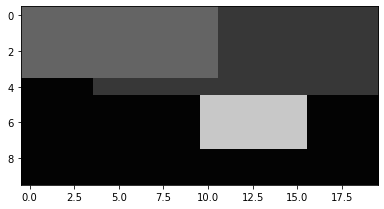

In [4]:
a.Show('normal')

Operators are generally applied on a per-pixel basis.

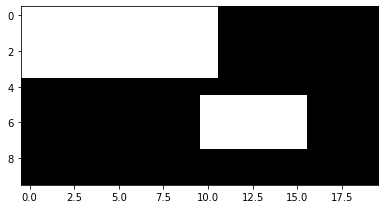

In [5]:
m = a >= 100
m.Show()

Images can be indexed by binary images, resulting in a 1D image containing only the selected pixels. Note that the order depends on the internal linear pixel storage order, which is not consistent with any specific (row-major or column-major) order due to operations such as `Rotation90` and `Mirror`.

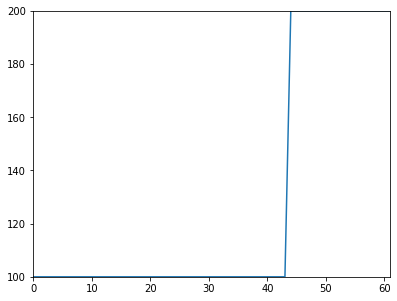

In [6]:
a[m].Show('normal')

Binary image indexing can also be used for assignment.

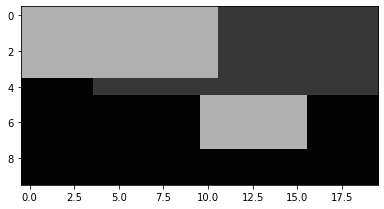

In [7]:
a[m] = 176
a.Show('normal')

An `Image` object uses the *NumPy* buffer interface. This means that you can use an `Image` object everywhere where you can use a *NumPy* array, and you can use a *NumPy* array anywhere where you would use an `Image` object.

Here we create a *NumPy* array and display it like it were an `Image` (remember that *NumPy* uses height as the first dimension and width as the second one, this is reverse from how *PyDIP* does it):

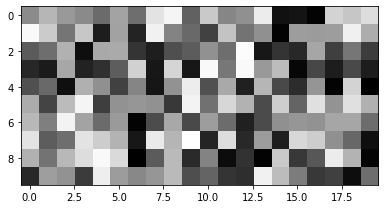

In [8]:
np.random.seed(0)
b = np.random.rand(a.Size(1), a.Size(0))
dip.Show(b)

Then we add the *NumPy* array to our image:

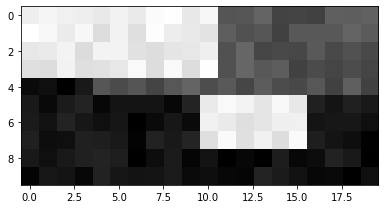

In [9]:
a += 30 * b
a.Show()

Then we call a *NumPy* function with an `Image` as input, and a *PyDIP* function with a *NumPy* `array` as input:

In [10]:
print(np.mean(a))
print(dip.Mean(b)[0][0])

85.16313
0.50043779790514


Note that the `Image` object can contain images of any number of dimensions, including 0 (a single pixel). The `Show` method only displays 1D or 2D images, for images with more dimensions, it will display a projection. Read this method's help to learn how to control the projection mode, etc. Alternatively, use `dip.viewer.Show` for an interactive image display that shows images with any number of dimensions.

## Loading images from file
*PyDIP* has an image reading function `dip.ImageRead`, which will use the built-in image readers (ICS, TIFF, JPEG) and, if available, the Bio-Formats image readers (which recognizes over a hundred different file types). It is also possible to use `imageio.v3.imread`, `matplotlib.pyplot.imread`, `cv2.imread`, etc.

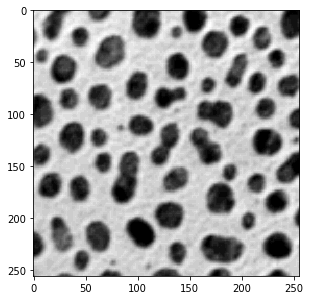

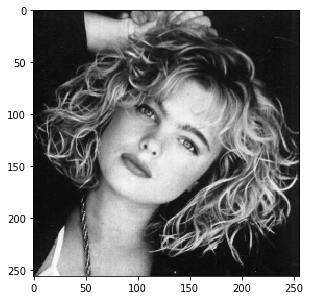

In [11]:
a = dip.ImageRead('../cermet.ics')
a.Show()
b = dip.Image(plt.imread('../erika.tif'))
b.Show()

## Color images
Color images are supported too, it's a bit different from what you're likely used to. A 2D color image is seen as 2D, each pixel has three values. This affects indexing! Here we give a little demo, we recommend that you look through the tensor image demo notebook to learn more about images with more than one value per pixel.

In [12]:
a = dip.ImageRead('../DIP.tif')
print(a)
print(a[50:100, :])       # spatial indexing is the same as for other 2D images!
print(a(0))               # this is the red channel
print(a[128, 45])         # this returns a Python list with all the values for the pixel
print(a[128, 45][0])      # this returns the red value of one pixel
print(a(0)[128, 45])      # this also, but as a Python list

2D Color image (3x1 column vector, 3 elements, sRGB):
    data type:      UINT8
    sizes:          {256, 256}
    strides:        {3, 768}, tensor stride 1
    data pointer:   0x1380c8000 (shared among 1 images)
    origin pointer: 0x1380c8000

2D Color image (3x1 column vector, 3 elements, sRGB):
    data type:      UINT8
    sizes:          {51, 256}
    strides:        {3, 768}, tensor stride 1
    data pointer:   0x1380c8000 (shared among 2 images)
    origin pointer: 0x1380c8096

2D Scalar image:
    data type:      UINT8
    sizes:          {256, 256}
    strides:        {3, 768}, tensor stride 1
    data pointer:   0x1380c8000 (shared among 2 images)
    origin pointer: 0x1380c8000

[210, 177, 18]
210
[210]


*PyDIP* knows [a lot of color spaces](https://diplib.org/diplib-docs/dip-ColorSpaceManager.html). The `Show` method automatically converts to RGB for display.

In [13]:
print(a.ColorSpace())
b = dip.ColorSpaceManager.Convert(a, 'Lab')
print(b.ColorSpace())

sRGB
Lab


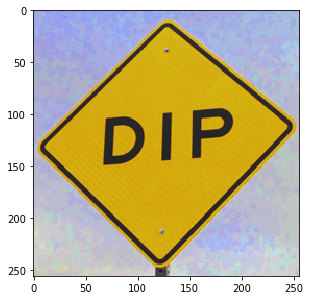

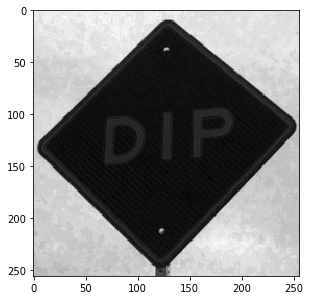

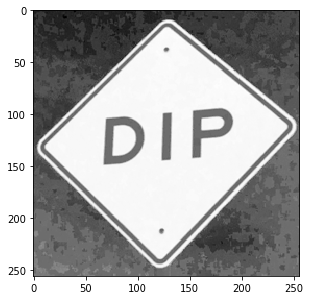

In [14]:
b.Show()
a(2).Show()  # B channel from RGB image
b(2).Show()  # b channel from Lab image

## Filtering
There are many image filtering functions available, which you can discover by exploring [the *DIPlib* documentation](https://diplib.org/diplib-docs/modules.html). Function names and parameters in Python are identical to the names in the *DIPlib* library. And just like in the *DIPlib* library, there exists a version of the function where the `out` parameter is the return value. Here we do some simple color filtering to demonstrate.

In [15]:
b = dip.Gauss(a, 5)

is the same as

In [16]:
b = dip.Image()
dip.Gauss(a, out=b, sigmas=5)

Note that the `out` parameter must always be given as a keyword argument, and all subsequent arguments as well. In the syntax that returns the output image, the keyword is optional.

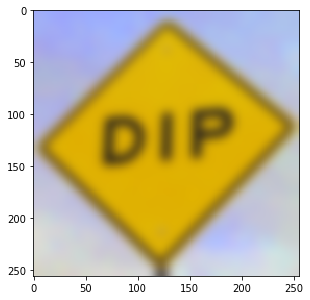

In [17]:
b.Show()

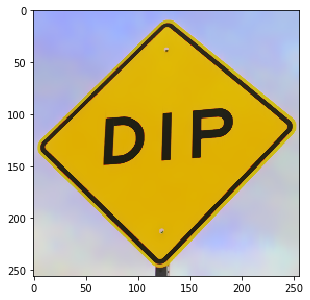

In [18]:
b = dip.BilateralFilter(a, spatialSigmas=5, tonalSigma=30)
b.Show()

Some filters are specific for gray-value images (these are called "scalar images" everywhere in the documentation). Here we apply such an image by first converting the image to gray scale.

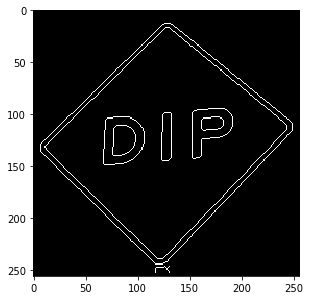

In [19]:
b = dip.ColorSpaceManager.Convert(b, 'gray')
dip.Canny(b, upper=0.99).Show()

## Measurement
`dip.MeasurementTool` can measure [quite a lot of features](https://diplib.org/diplib-docs/features.html) for objects in an image. This is a simple example usage.

We first read the 'cermet' image, and record its pixel size (this is an old example image, the actual pixel size has gotten lost over the years). If an image contains the pixel size in the metadata, it will automatically be recorded in the `Image` object and used by measurement functions and some other functions. Note that pixels do not need to be isotropic, it is possible to give a different pixel size for each dimension.

{1 μm}


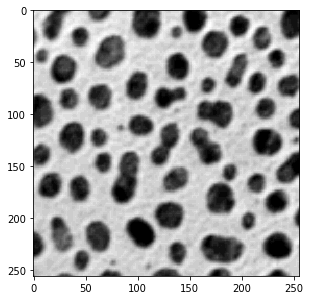

In [20]:
a = dip.ImageReadICS('../cermet')
a.SetPixelSize(1, "um")
print(a.PixelSize())
a.Show()

Next, we threshold and label the image, then measure some basic features. Because 'Solidity' depends on the 'ConvexArea' measurement, we get that one too in the output.

In [21]:
b = a < 120
b = dip.EdgeObjectsRemove(b)
b = dip.Label(b, minSize=30)
m = dip.MeasurementTool.Measure(b, a, ['Size', 'Solidity', 'Statistics'])
print(m)

   |       Size |   Solidity |                                            Statistics | ConvexArea | 
-- | ---------- | ---------- | ----------------------------------------------------- | ---------- | 
   |            |            |       Mean |     StdDev |   Skewness | ExcessKurtosis |            | 
   |      (μm²) |            |            |            |            |                |      (μm²) | 
-- | ---------- | ---------- | ---------- | ---------- | ---------- | -------------- | ---------- | 
 1 |      262.0 |     0.9668 |      45.34 |      30.82 |     0.7216 |        -0.6831 |      271.0 | 
 2 |      63.00 |     0.9474 |      86.35 |      13.41 |     0.2313 |        -0.5471 |      66.50 | 
 3 |      243.0 |     0.9293 |      75.09 |      21.16 |     0.1711 |        -0.9723 |      261.5 | 
 4 |      209.0 |     0.9698 |      61.63 |      25.80 |     0.3937 |        -0.7994 |      215.5 | 
 5 |      462.0 |     0.9665 |      62.10 |      20.27 |     0.7329 |         0.1613 |     

The `dip.Measurement` object `m` can be indexed in three levels: the measurement name ('Statistics'), the object number (30), and the measurement value within the selected measurement (2):

In [22]:
print(m['Statistics'][30])
print(m['Statistics'][30][2])
print(m[30]['Statistics'][2])

[51.05454545454547, 27.733471736251396, 0.6729066879016448, -0.5471176839610813]
0.6729066879016448
0.6729066879016448


Leaving out one of the indices returns the full row or column:

In [23]:
print(m[30])
print(m['Solidity'])

<MeasurementObject with 4 features for object 30>
<MeasurementFeature for feature Solidity and 43 objects>


These objects can be indexed further as above, or be converted to a *NumPy* array:

In [24]:
print(np.asarray(m[30]))
print(np.asarray(m['Solidity']).transpose())

[[385.           0.96370463  51.05454545  27.73347174   0.67290669
   -0.54711768 399.5       ]]
[[0.96678967 0.94736842 0.9292543  0.96983759 0.9665272  0.97448166
  0.98159509 0.97619048 0.98356808 0.90410959 0.974      0.97455471
  0.97087379 0.97857143 0.96675192 0.90426759 0.97457627 0.96857671
  0.9245283  0.97567954 0.97470817 0.85802469 0.88888889 0.97175141
  0.97923875 0.92680242 0.96759259 0.95454545 0.9765625  0.96370463
  0.9612069  0.97335203 0.95268139 0.9738652  0.96964286 0.95145631
  0.9        0.97138047 0.971652   0.98130841 0.96340732 0.97495183
  0.97721519]]


We can paint the objects with one of the measurements, which can be useful for display:

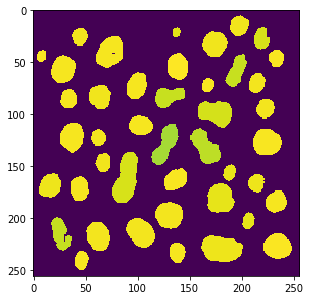

In [25]:
c = dip.ObjectToMeasurement(b, m['Solidity'])
c.Show(colormap='viridis')

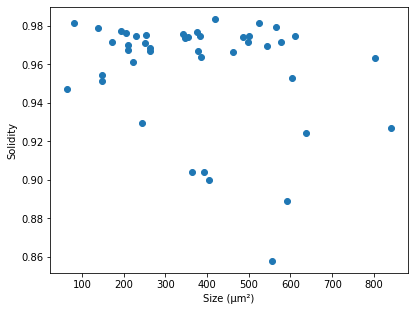

In [26]:
plt.scatter(np.asarray(m['Size']), np.asarray(m['Solidity']))
plt.xlabel('Size (μm²)')
plt.ylabel('Solidity');